# Step 1: Load up data from the file

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import dateutil.parser as dp
import re
import time
import pytz

In [2]:
import pickle
import pathlib

wu_data_cache_filename = './weatherunderground_data_cache.db'

if pathlib.Path(wu_data_cache_filename).is_file():
    wu_data = pickle.load(open(wu_data_cache_filename, 'rb'))

In [3]:
with open('light_events', 'r') as f:
    raw_events = [l.strip() for l in f]

In [4]:
tz_data = {'PDT' : -7*3600, 'PST' : -8*3600}

events = [re.match('^(switch|light) (.+)$', l).groups() for l in raw_events]
events = [(dp.parse(ts, tzinfos=tz_data), ev) for ev, ts in events]

In [5]:
def parse_events(events):
    switchon = False
    rv = {}
    
    for ts, ev in events:
        if switchon:
            if ev == 'light':
                rv['light'] = ts
                yield(rv)
                rv = {}
                switchon = False
            else:
                rv = {}
        else:
            rv['switch'] = ts
            switchon = True
            
events = pd.DataFrame([x for x in parse_events(events)])

In [6]:
events['minutes'] = events[['switch', 'light']].apply(lambda x: (x[1] - x[0]).seconds/60, axis=1)

## Step 2: Merge in data from Weather Underground

There is a maximum of 10 API calls per minutes so this can take some time.

In [7]:
import requests

wu_api_key = 'FIXME'
api_base = 'https://api.wunderground.com/api/{}/history_{}/q/WA/Seattle.json'

In [8]:
# convert the wu date objects into datetimes
def obs_to_datetime(x):
    x = x['utcdate']
    numbers = [int(i) for i in [x['year'], x['mon'], x['mday'], x['hour'], x['min']]]
    date_obj = datetime(*numbers, tzinfo=pytz.UTC)
    #date_obj = date_obj.replace(tzinfo=pytz.UTC)
    return(date_obj)

# fetch any addition data from the wu api
first_fetch = True
for date_string in [datetime.strftime(x, format='%Y%m%d') for x in pd.concat([events["light"], events["switch"]])]:
    if ('wu_data' not in locals()) or (date_string not in wu_data['date_string'].unique()):
        # wait 6 seconds if it's our first time through
        if first_fetch:
            first_fetch = False
        else:
            time.sleep(6)
        
        api_url = api_base.format(wu_api_key, date_string)

        r = requests.get(api_url)
        payload = r.json()

        day_data = pd.DataFrame({'date_string' : date_string,
                                 'time_stamp' : [obs_to_datetime(x) for x in payload['history']['observations']],
                                 'temp_c' : [float(x['tempm']) for x in payload['history']['observations']]
                                })
        if 'wu_data' not in locals():
            wu_data = day_data
        else:
            wu_data = wu_data.append(day_data)
        
        print("Fetching: " + date_string)

# sort and then save the current data to the pickle/cache
wu_data = wu_data.sort_values("time_stamp")
pickle.dump(wu_data, open(wu_data_cache_filename, 'wb'))

In [9]:
wu_data_indexed = wu_data.set_index('time_stamp')

In [10]:
# add the temperature data
def get_nearest_temp(ts):
    i = wu_data_indexed.index.get_loc(ts, method='nearest')
    return(wu_data_indexed.iloc[i]['temp_c'])

events['temp_c'] = events['switch'].apply(get_nearest_temp)

/tmp/ipykernel_326982/892703484.py:3: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  i = wu_data_indexed.index.get_loc(ts, method='nearest')


In [11]:
events['temp_k'] = events["temp_c"] + 273.15

In [12]:
events

,switch,light,minutes,temp_c,temp_k
0,2017-06-20 10:22:49-07:00,2017-06-20 11:53:10-07:00,90.350000,16.7,289.85
1,2017-06-21 17:03:12-07:00,2017-06-21 18:26:52-07:00,83.666667,19.4,292.55
2,2017-06-22 17:49:49-07:00,2017-06-22 18:44:27-07:00,54.633333,22.2,295.35
3,2017-06-23 17:03:34-07:00,2017-06-23 17:41:39-07:00,38.083333,25.6,298.75
4,2017-06-25 12:04:36-07:00,2017-06-25 12:32:36-07:00,28.000000,27.8,300.95
5,2017-06-26 17:39:02-07:00,2017-06-26 18:12:36-07:00,33.566667,22.2,295.35
6,2017-06-27 10:46:53-07:00,2017-06-27 11:37:43-07:00,50.833333,15.6,288.75
7,2017-07-02 17:29:02-07:00,2017-07-02 18:22:00-07:00,52.966667,23.9,297.05
8,2017-07-10 10:10:01-07:00,2017-07-10 10:57:42-07:00,47.683333,17.2,290.35
9,2017-07-10 22:14:36-07:00,2017-07-10 22:50:46-07:00,36.166667,16.7,289.85


## Step 3: Graph and analyze data

In [13]:
%matplotlib inline

# import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

Simple histographs and graphs over time

<AxesSubplot: >

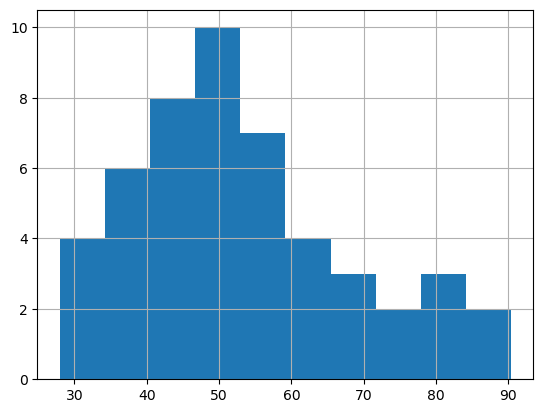

In [14]:
events['minutes'].hist()

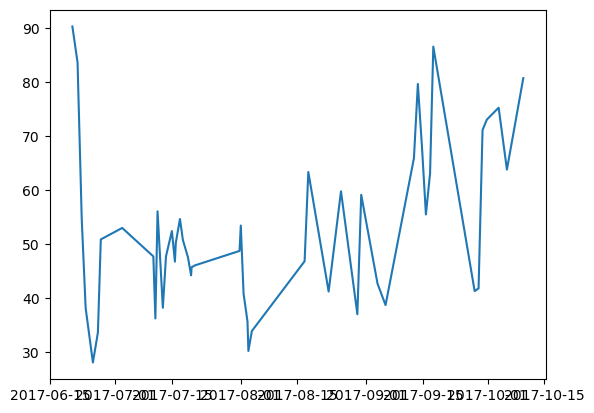

In [15]:
plt.plot(events['switch'], events['minutes'])

Text(0, 0.5, 'minutes')

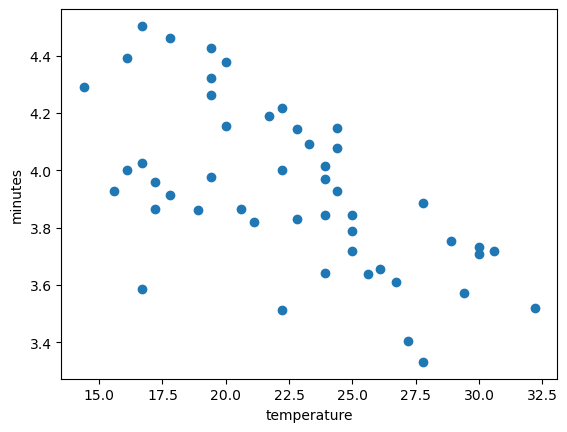

In [16]:
plt.scatter(events['temp_c'], np.log(events['minutes']))
plt.xlabel('temperature')
plt.ylabel('minutes')

In [17]:
from scipy.stats import spearmanr

spearmanr(events['minutes'], events['temp_c'], axis=None)

SignificanceResult(statistic=-0.6214984466030088, pvalue=1.8820956805749064e-06)

In [18]:
#add a log version of minutes
events["minutes_log"] = np.log(events["minutes"])

In [20]:
import statsmodels.api as sm
model = sm.OLS(events["minutes"], sm.add_constant(events["temp_c"]))

print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                minutes   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     26.05
Date:                Wed, 24 May 2023   Prob (F-statistic):           5.92e-06
Time:                        12:02:57   Log-Likelihood:                -192.28
No. Observations:                  49   AIC:                             388.6
Df Residuals:                      47   BIC:                             392.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         98.7251      9.154     10.785      0.0

In [21]:
import statsmodels.formula.api as sm
model = sm.ols(formula="minutes ~ temp_c", data=events)

print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                minutes   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     26.05
Date:                Wed, 24 May 2023   Prob (F-statistic):           5.92e-06
Time:                        12:03:07   Log-Likelihood:                -192.28
No. Observations:                  49   AIC:                             388.6
Df Residuals:                      47   BIC:                             392.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     98.7251      9.154     10.785      0.0

Interpretation is that the a one degree change is associated with a (coef for temp_k is * 100) change in time.

Text(0, 0.5, 'log(minutes)')

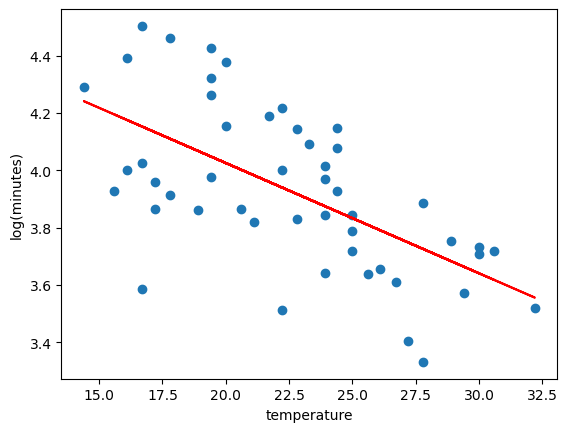

In [22]:
fit = np.polyfit(events['temp_c'], events['minutes'].apply(np.log), deg=1)

plt.scatter(events['temp_c'], events['minutes'].apply(np.log))
plt.plot(events['temp_c'], fit[0] * events['temp_c'] + fit[1], color='red')

plt.xlabel('temperature')
plt.ylabel('log(minutes)')

In [23]:
import statsmodels.api as sm
model = sm.OLS(events["minutes"], events["temp_c"])

print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                minutes   R-squared (uncentered):                   0.828
Model:                            OLS   Adj. R-squared (uncentered):              0.825
Method:                 Least Squares   F-statistic:                              231.3
Date:                Wed, 24 May 2023   Prob (F-statistic):                    5.52e-20
Time:                        12:03:12   Log-Likelihood:                         -222.80
No. Observations:                  49   AIC:                                      447.6
Df Residuals:                      48   BIC:                                      449.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [25]:
events.corr()

/tmp/ipykernel_326982/2842044647.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  events.corr()


,minutes,temp_c,temp_k,minutes_log
minutes,1.000000,-0.597147,-0.597147,0.987181
temp_c,-0.597147,1.000000,1.000000,-0.612309
temp_k,-0.597147,1.000000,1.000000,-0.612309
minutes_log,0.987181,-0.612309,-0.612309,1.000000


In [55]:
events[["minutes", "temp_c"]].corr()

,minutes,temp_c
minutes,1.000000,-0.597147
temp_c,-0.597147,1.000000


<AxesSubplot: >

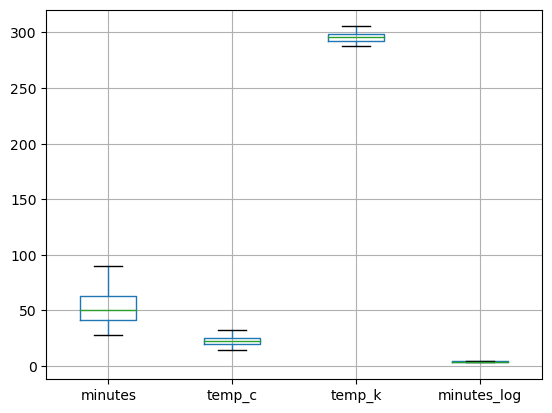

In [26]:
events.boxplot()